[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/danimateos/hotdog-nohotdog/blob/master/06-On_the_shoulders_of_giants.ipynb)

# On the shoulders of giants

Hi there!

[Last time], we managed to get our [hotdog detector] to around 0.20 loss (binary cross entropy, a convenient loss measure for binary classification), which translated into 92% accuracy. But Jian-Yang is not yet happy- we won't rest until we reach at least 95%!

We kind of reached the limits of our network but not quite. We could push it a bit more, but it would be no match for some networks out there pushed by the likes of [DeepMind] or [OpenAI]. These are industrial research labs with huge budgets. For example, a single training run of AlphaGo Zero, the more refined version of AlphaGo, has been [estimated] to cost millions of dollars! And you have to do scores of those while you are trail-or-error-ing your way to a useful network.

It would be great if we could take their work and not have to replicate it on our dime, wouldn't it? Well, as you might have guessed, we can. Tobegin with, we can take their network architecture. That is the precise combination of layers they use. There are a bunch of famous architectures like for example [AlexNet], the one that revolutionized the ImageNet competition, as I wrote about [earlier]. 

![VGG16](https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network.jpg)

We are going to use [VGG16], pictured above, just because it is quite better than ImageNet and it's easily available within Keras, but there are far [more powerful ones] out there now.

What then? 

[hotdog detector]: https://www.youtube.com/watch?v=ACmydtFDTGs
[VGG16]: https://neurohive.io/en/popular-networks/vgg16/
[Last time]: http://mateos.io/blog/making_the_most_of_little/
[DeepMind]: https://deepmind.com/
[OpenAI]: https://openai.com/
[estimated]: https://keplerlounge.com/artificial/intelligence/2019/03/24/alpha-go-zero.html
[AlexNet]: https://towardsdatascience.com/alexnet-the-architecture-that-challenged-cnns-e406d5297951
[earlier]: http://mateos.io/blog/getting-some-hotdogs/
[more powerful ones]: https://keras.io/applications/

# Transfer Learning

The cool trick that allows us to use this huge net for our particular problem is called Transfer Learning and it's actually really intuitive. Basically, we chop off the top of the net, then attach our own extension. 

Remember in an [earlier post](http://mateos.io/blog/my-first-hotdog-detector/) in this series when I said that higher layers recognize increasingly elaborate features? Well, if we trained this network on the ~5500 images we have, it would have to learn to recognize even the most basic forms (straight lines, curves) from a very small set. With transfer learning, we take a network that has been pretrained on maybe millions of images and learnt to recognize very complex patterns and we keep only the most widely applicable part. Then, on the output of that, we attach a small easily trainable network.

In [1]:
# Delete this line if you are not running the notebook in colab
%tensorflow_version 1.x 
# Silence some annoying deprecation warnings
import logging
logging.getLogger('tensorflow').disabled = True

import keras
from keras import backend as K
from keras.applications import VGG16

vgg = VGG16(weights='imagenet', # This will download the neuron weights
            include_top=False, 
            input_shape=(120,120,3))

Using TensorFlow backend.


Notice that we want to freeze the pretrained part: the weights in the part that we attach are very far from optimum, while those under them are very close. If we let them change at the same learning rate as the top part, backpropagation is going to mean that the bottom weights "flay around" and the whole thing turns useless.

In [2]:
from keras.layers import Dense, Flatten

model = keras.Sequential()
vgg.trainable = False # Freeze VGG
model.add(vgg)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 15,329,473
Trainable params: 614,785
Non-trainable params: 14,714,688
____________________________________

Set up everything to train the classifier...

In [3]:
from keras.preprocessing.image import ImageDataGenerator
import os

# Download the data
!wget -q "https://www.dropbox.com/s/dhpekpce05iev6a/data_v2.zip?dl=0" -O data.zip
!rm -rf data/
!unzip -oq data.zip
!ls -lh data

# Download utility functions
!wget https://www.dropbox.com/s/qsyoi591pkltsvy/mateosio.py?dl=0 -O mateosio.py

base_dir = 'data/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(rescale=1 / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1 / 255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(120,120),
                                                    batch_size=100,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(120,120),
                                                        batch_size=100,
                                                        class_mode='binary')

validation_generator_noshuffle = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(120,120),
                                                        batch_size=100,
                                                        shuffle=False,                                                            
                                                        class_mode='binary') 

total 12K
drwxrwxr-x 4 root root 4.0K Jun 27  2018 test
drwxrwxr-x 4 root root 4.0K Jun 27  2018 train
drwxrwxr-x 4 root root 4.0K Jun 27  2018 validation
--2020-02-14 13:40:53--  https://www.dropbox.com/s/qsyoi591pkltsvy/mateosio.py?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qsyoi591pkltsvy/mateosio.py [following]
--2020-02-14 13:40:55--  https://www.dropbox.com/s/raw/qsyoi591pkltsvy/mateosio.py
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdc4b53afe72a910331b5972fdc.dl.dropboxusercontent.com/cd/0/inline/AyFMRMCMEEVS40JICEH3aw4NxqgdQc23TZPvmM7mGVKshY2cD2Ms9DYBs8CBKqDeUHzWggCRFwZLN5CIraksuefFkjB4k7tznsMeLXjmRZWFC8efu16WVnNLBgJkAyg28fs/file# [following]
--2020-02-14 13:40:55--  https://ucdc4b53afe72a910331b597

We are set up! let's train this.

In [4]:
from keras.optimizers import Adam

model.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['acc'])

history = model.fit_generator(train_generator,
                              class_weight = {0: 7, 1: 1},
                              steps_per_epoch=30,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=10)

Epoch 1/30
30/30 [==============================] - 32s 1s/step - loss: 0.8916 - acc: 0.7391 - val_loss: 0.3156 - val_acc: 0.8664
Epoch 2/30
30/30 [==============================] - 25s 831ms/step - loss: 0.7594 - acc: 0.8158 - val_loss: 0.2722 - val_acc: 0.9150
Epoch 3/30
30/30 [==============================] - 26s 865ms/step - loss: 0.6429 - acc: 0.8380 - val_loss: 0.2060 - val_acc: 0.9342
Epoch 4/30
30/30 [==============================] - 25s 848ms/step - loss: 0.6424 - acc: 0.8383 - val_loss: 0.2196 - val_acc: 0.9211
Epoch 5/30
30/30 [==============================] - 26s 857ms/step - loss: 0.5544 - acc: 0.8573 - val_loss: 0.2076 - val_acc: 0.9150
Epoch 6/30
30/30 [==============================] - 26s 859ms/step - loss: 0.5537 - acc: 0.8640 - val_loss: 0.2301 - val_acc: 0.9079
Epoch 7/30
30/30 [==============================] - 25s 847ms/step - loss: 0.5621 - acc: 0.8576 - val_loss: 0.2346 - val_acc: 0.8947
Epoch 8/30
30/30 [==============================] - 25s 837ms/step - los

Well, it does seem promising, doesn't it? Let's see how it performs! Remember that we had around 45% precision 87% recall.

0.6624203821656051 0.9122807017543859


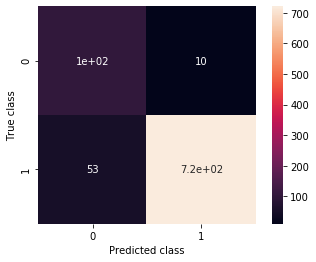

In [5]:
from mateosio import plot_confusion_matrix
%matplotlib inline

ax, precision, recall = plot_confusion_matrix(model, validation_generator_noshuffle)
print(precision, recall)

Wow! that's quite the boost from something so simple, right? Well, what we did was simple, but it took advantage of the work of many smart people, and what they did was not that simple.

Now, we can keep training. We got a lot closer to the optimal weights, so it's probably good to reduce the learning rate in order to fine tune rather than jump around the loss landscape.

In [6]:
model.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-4),
                     metrics=['acc'])

history_pt2 = model.fit_generator(train_generator,
                                  class_weight = {0: 7, 1: 1},
                                  steps_per_epoch=30,
                                  epochs=30,
                                  validation_data=validation_generator,
                                  validation_steps=10)

model.save('vgg_frozen_convbase.h5')

Epoch 1/30
30/30 [==============================] - 28s 918ms/step - loss: 0.3849 - acc: 0.9015 - val_loss: 0.1811 - val_acc: 0.9332
Epoch 2/30
30/30 [==============================] - 26s 872ms/step - loss: 0.3896 - acc: 0.9073 - val_loss: 0.1831 - val_acc: 0.9322
Epoch 3/30
30/30 [==============================] - 26s 881ms/step - loss: 0.3923 - acc: 0.8977 - val_loss: 0.2100 - val_acc: 0.9200
Epoch 4/30
30/30 [==============================] - 26s 860ms/step - loss: 0.3822 - acc: 0.8933 - val_loss: 0.1831 - val_acc: 0.9332
Epoch 5/30
30/30 [==============================] - 26s 866ms/step - loss: 0.3888 - acc: 0.8988 - val_loss: 0.1725 - val_acc: 0.9312
Epoch 6/30
30/30 [==============================] - 25s 837ms/step - loss: 0.3975 - acc: 0.8925 - val_loss: 0.2150 - val_acc: 0.9140
Epoch 7/30
30/30 [==============================] - 25s 849ms/step - loss: 0.3662 - acc: 0.9083 - val_loss: 0.1973 - val_acc: 0.9221
Epoch 8/30
30/30 [==============================] - 26s 852ms/step - 

0.6309523809523809 0.9298245614035088


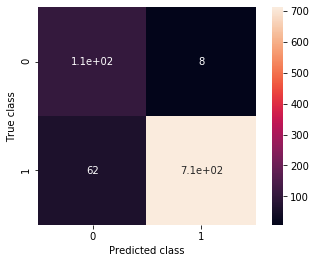

In [7]:
ax, precision, recall = plot_confusion_matrix(model, validation_generator_noshuffle)
print(precision, recall)

Notice that our model, now, has less free parameters than the original one: now we are only training the fully connected layers at the top. This improvement is wholly due to the convolutional filters in VGG16 having learned more useful features than our convolutional layers, even though they where trained for a (somewhat) different task!! Isn't that cool?

In practice, my guess is that it's both due to higher complexity in the convolutional base and many more training samples. Not to mention the experience and knowledge of the scientists that designed VGG! That's what I meant by "standing on the shoulders of giants". These guys spent years of their life, thousands of hours of work, and a lot of money and GPU time to train this network. Now we get it for free with little more than an import. Sometimes progress is awesome.









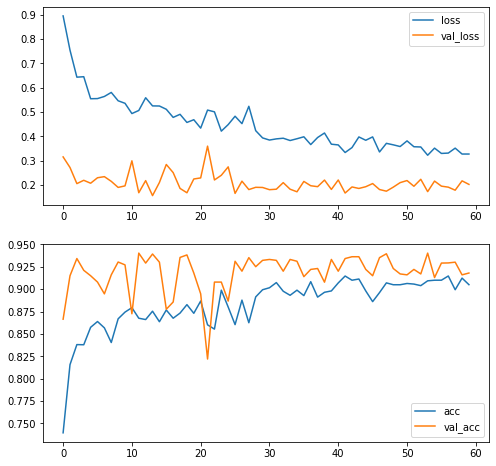

In [8]:
from mateosio import plot_training_histories
%matplotlib inline

plot_training_histories(history, history_pt2);

### Fine Tuning

We can keep improving this if we fine tune the model to our purposes. We'll only thaw the top part of VGG: the one that is marked as block 5.

In [9]:
# The VGG16 inside my model:

model.layers[0].summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0     

In [0]:
for layer in model.layers[0].layers:
    if 'block5' in layer.name: 
        layer.trainable = True
    else: 
        layer.trainable = False
        
# Set the vgg as a whole to trainable:        
model.layers[0].trainable = True   

In [11]:
[layer.trainable for layer in model.layers[0].layers]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True]

Now we keep training the model. This time we will be updating the top few layers. We want to reduce the learning rate in order to keep them from 'flailing around'

At first the loss and accuracy get worse, but they will start improving soon enough.

In [12]:
model.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-5),
                     metrics=['acc'])

history_pt2 = model.fit_generator(train_generator,
                                  class_weight = {0: 7, 1: 1},
                                  steps_per_epoch=30,
                                  epochs=30,
                                  validation_data=validation_generator,
                                  validation_steps=10)

model.save('vgg_unfrozen_convbase_30epochs.h5')

Epoch 1/30
30/30 [==============================] - 29s 955ms/step - loss: 0.3110 - acc: 0.9158 - val_loss: 0.1765 - val_acc: 0.9352
Epoch 2/30
30/30 [==============================] - 27s 890ms/step - loss: 0.3614 - acc: 0.9033 - val_loss: 0.1775 - val_acc: 0.9241
Epoch 3/30
30/30 [==============================] - 27s 906ms/step - loss: 0.3365 - acc: 0.9147 - val_loss: 0.2080 - val_acc: 0.9251
Epoch 4/30
30/30 [==============================] - 26s 876ms/step - loss: 0.3089 - acc: 0.9243 - val_loss: 0.1638 - val_acc: 0.9453
Epoch 5/30
30/30 [==============================] - 26s 861ms/step - loss: 0.2928 - acc: 0.9178 - val_loss: 0.1972 - val_acc: 0.9261
Epoch 6/30
30/30 [==============================] - 27s 910ms/step - loss: 0.3262 - acc: 0.9187 - val_loss: 0.1640 - val_acc: 0.9393
Epoch 7/30
30/30 [==============================] - 26s 861ms/step - loss: 0.2823 - acc: 0.9303 - val_loss: 0.1931 - val_acc: 0.9251
Epoch 8/30
30/30 [==============================] - 27s 891ms/step - 

0.7142857142857143 0.9210526315789473


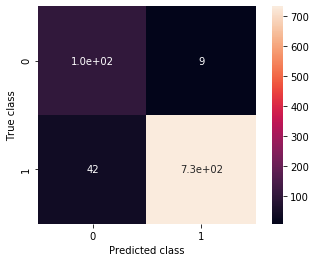

In [13]:
ax, precision, recall = plot_confusion_matrix(model, validation_generator_noshuffle)
print(precision, recall)

In [14]:
model.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-5),
                     metrics=['acc'])

history_pt3 = model.fit_generator(train_generator,
                                  class_weight = {0: 7, 1: 1},
                                  steps_per_epoch=30,
                                  epochs=30,
                                  validation_data=validation_generator,
                                  validation_steps=10)

model.save('vgg_unfrozen_convbase_60epochs.h5')

Epoch 1/30
30/30 [==============================] - 28s 949ms/step - loss: 0.1602 - acc: 0.9630 - val_loss: 0.1335 - val_acc: 0.9575
Epoch 2/30
30/30 [==============================] - 26s 879ms/step - loss: 0.1326 - acc: 0.9653 - val_loss: 0.1490 - val_acc: 0.9575
Epoch 3/30
30/30 [==============================] - 27s 896ms/step - loss: 0.1569 - acc: 0.9613 - val_loss: 0.1319 - val_acc: 0.9585
Epoch 4/30
30/30 [==============================] - 26s 879ms/step - loss: 0.1525 - acc: 0.9670 - val_loss: 0.1294 - val_acc: 0.9575
Epoch 5/30
30/30 [==============================] - 26s 869ms/step - loss: 0.1776 - acc: 0.9550 - val_loss: 0.1558 - val_acc: 0.9545
Epoch 6/30
30/30 [==============================] - 27s 895ms/step - loss: 0.1574 - acc: 0.9623 - val_loss: 0.1535 - val_acc: 0.9565
Epoch 7/30
30/30 [==============================] - 27s 898ms/step - loss: 0.1575 - acc: 0.9590 - val_loss: 0.1409 - val_acc: 0.9555
Epoch 8/30
30/30 [==============================] - 27s 884ms/step - 

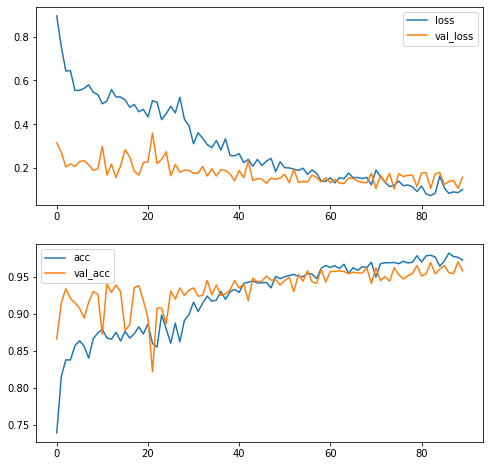

In [15]:
plot_training_histories(history, history_pt2, history_pt3);

0.8253968253968254 0.9122807017543859


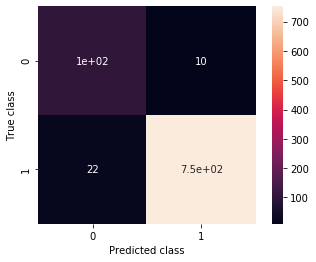

In [16]:
ax, precision, recall = plot_confusion_matrix(model, validation_generator_noshuffle)
print(precision, recall)

Well, we did manage to get us some of that sweet sweet overfitting, didn't we? Notice how the training loss had gotten kind of stuck there until we lowered the learning rate. 

In this case, unfreezing the top of the convolutional stack didn't help us a lot, possibly because VGG16 was trained on ImageNet so the features it recognizes are already very applicable.

In any case, I feel that there is still some performance here that we can squeeze out. What do you say, we apply some more regularization so that we can train even more?? We'll do that in the next part of this series.

### Further Reading

[Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python): A great introductory book by  François Chollet, author of Keras. Explains the practice first, then goes down to theory.

[DeepMind's blog entry on AlphaGo Zero, the self-taught version of AlphaGo](https://deepmind.com/blog/article/alphago-zero-starting-scratch)

[Keras applications](https://keras.io/applications/): pretrained models available within Keras